## Stats 101C Final Project: Sentiment Analysis of IMDB Ratings
### Anvesha Dutta

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, f1_score
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV

ModuleNotFoundError: No module named 'wordcloud'

In [85]:
imdb_data = pd.read_csv("updated_file.csv", encoding='utf-8', error_bad_lines=False, engine="python")

In [86]:
# # Read in positive and negative opinion lexicon files
# with open('positive-words.txt', 'r') as positive_file:
#     positive_words = [line.strip() for line in positive_file]

# with open('negative-words.txt', 'r') as negative_file:
#     negative_words = negative_file.read().split('\n')

# def filter_words(review, pos_words, neg_words):
#     tokens = word_tokenize(review)
#     filtered_tokens = [token for token in tokens if token in pos_words or token in neg_words]
#     return ' '.join(filtered_tokens)

# imdb_data['lexicon_reviews'] = imdb_data['review'].apply(lambda x: filter_words(x, positive_words, negative_words))
# imdb_data.to_csv('updated_file.csv', index=False)

In [87]:
imdb_data.head()

,review,sentiment,lexicon_reviews
0,One of the other reviewers has mentioned that ...,positive,right struck brutality right faint timid class...
1,A wonderful little production. <br /><br />The...,positive,wonderful comforting well seamless well worth ...
2,I thought this was a wonderful way to spend ti...,positive,wonderful hot light-hearted plot simplistic wi...
3,Basically there's a family where a little boy ...,negative,zombie slower kill like ruins meaningless well...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,stunning vivid success sophisticated luxurious...


In [88]:
imdb_data.describe()

,review,sentiment,lexicon_reviews
count,50000,50000,49939
unique,49582,2,49429
top,Loved today's show!!! It was a variety and not...,positive,like
freq,5,25000,10


In [89]:
imdb_data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

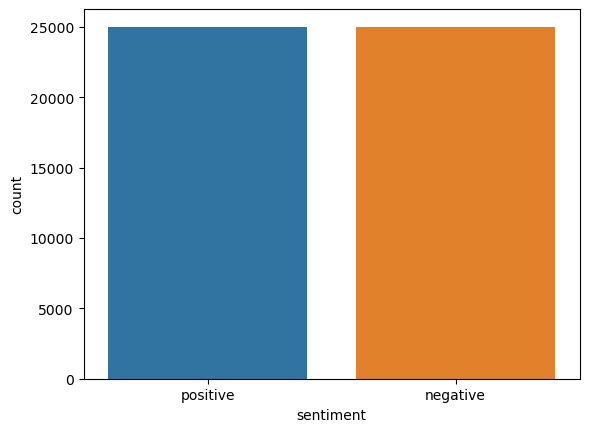

In [90]:
sns.countplot(x='sentiment', data=imdb_data)

balanced dataset

Mean length of a review of each type

In [91]:
imdb_data.groupby('sentiment').agg(mean_review_len = ('review', lambda x: x.str.len().mean()))

,mean_review_len
sentiment,
negative,1294.06436
positive,1324.79768


Text Cleaning Functions

In [92]:
#removing html strips
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    text = html_tag.sub(r'', text)
    return text

#remove URL data
def remove_url(text):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    text = url_clean.sub(r'', text)
    return text

#removing square brackets 
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#removing noisy data 
def remove_noise(text):
    text=remove_html(text)
    text=remove_url(text)
    text=remove_brackets(text)
    return text 

#remove special characters
def remove_special_chars(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text=re.sub(pattern, '', text)
    return text.lower()


#final text preparation function 
def text_prep(text):
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)

    text=remove_noise(text)
    text=remove_special_chars(text)
    return text


In [93]:
imdb_data['review'] = imdb_data['review'].apply(text_prep)

In [94]:
imdb_data.review

0        one of the other reviewers has mentioned that ...
1        a wonderful little production the filming tech...
2        i thought this was a wonderful way to spend ti...
3        basically there  a family where a little boy j...
4        petter mattei  love in the time of money is a ...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

Text normalization

In [95]:
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

Text Lemmatization

In [96]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    output = ''
    for word in text:
        output += lemmatizer.lemmatize(word)
    return output 
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(lemmatize)

Removing Stopwords

In [97]:
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    final_text = ' '.join(filtered_tokens)
    return final_text
imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)

Labeling the Sentiment Text

In [98]:
label = LabelBinarizer()
imdb_data['sentiment'] = label.fit_transform(imdb_data['sentiment'])
imdb_data

,review,sentiment,lexicon_reviews
0,one reviewers mentioned watching 1 oz episode ...,1,right struck brutality right faint timid class...
1,wonderful little production filming technique ...,1,wonderful comforting well seamless well worth ...
2,thought wonderful way spend time hot summer we...,1,wonderful hot light-hearted plot simplistic wi...
3,basically family little boy jake thinks zombie...,0,zombie slower kill like ruins meaningless well...
4,petter mattei love time money visually stunnin...,1,stunning vivid success sophisticated luxurious...
...,...,...,...
49995,thought movie right good job creative original...,1,right good creative fun like great horrible cl...
49996,bad plot bad dialogue bad acting idiotic direc...,0,plot bad bad idiotic annoying overacted crappy...
49997,catholic taught parochial elementary schools n...,0,good bad killed figurehead well fake lead bigo...
49998,im going disagree previous comment side maltin...,0,disagree excessively vicious creaks steady lik...


#### Using the reviews as they are 

Test Train Split

In [99]:
X = imdb_data['review']
y = imdb_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_train.shape)

(40000,) (40000,)
(10000,) (40000,)


Bag of Words Embedding

In [100]:
cv = CountVectorizer(ngram_range=(1,3))
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
print("BoW_cv_train:", cv_X_train.shape)
print("Bow_cv_test:", cv_X_test.shape)

BoW_cv_train: (40000, 7248842)
Bow_cv_test: (10000, 7248842)


TF-IDF Embedding

In [101]:
tf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tv_X_train = tf.fit_transform(X_train)
tv_X_test = tf.transform(X_test)
print("Tfidf_train:", tv_X_train.shape)
print("Tfidf_test:", tv_X_test.shape)

Tfidf_train: (40000, 6633778)
Tfidf_test: (10000, 6633778)


## Fitting Models

### 1. Logistic Regression

In [112]:
lr_bow_m = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
#fitting the model for Bag of Words embeddings 
lr_bow = lr_bow_m.fit(cv_X_train, y_train)
lr_bow_predict = lr_bow_m.predict(cv_X_test)
#fitting the model for the tfidf embeddings 
lr_tfidf_m = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
lr_tfidf = lr_tfidf_m.fit(tv_X_train, y_train)
lr_tfidf_predict = lr_tfidf_m.predict(tv_X_test)

In [113]:
#accuracy scores of both models 
lr_bow_score = accuracy_score(y_test, lr_bow_predict)
lr_tfidf_score = accuracy_score(y_test, lr_tfidf_predict)
print("Logistic Regression with Bag of Words Embeddings:", lr_bow_score)
print("Logistic Regression with TF-IDF Embeddings:", lr_tfidf_score)

Logistic Regression with Bag of Words Embeddings: 0.8993
Logistic Regression with TF-IDF Embeddings: 0.8802


Logistic Regression with Bag of Words Embeddings: 0.8993\
Logistic Regression with TF-IDF Embeddings: 0.8802

Hyperparameter tuning for Logistic Regression

In [136]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 300, 500]
}
grid_search = GridSearchCV(lr_bow_m, param_grid, cv=5, scoring='accuracy')
grid_search.fit(cv_X_train, y_train)
best_lr_bow_model = grid_search.best_estimator_
best_lr_bow_params = grid_search.best_params_
y_pred_ht = best_lr_bow_model.predict(cv_X_test)
accuracy_ht = accuracy_score(y_test, y_pred_ht)
print("Best Hyperparameters:", best_lr_bow_params)
print("Accuracy of the Best Logistic Regression Model after Hyperparameter Tuning:", accuracy_ht)

Best Hyperparameters: {'C': 0.1, 'max_iter': 100}
Accuracy of the Best Logistic Regression Model after Hyperparameter Tuning: 0.8499


Printing the metrics for Logistic Regression with BoW

In [114]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print("Logistic Regression with BoW:\n", lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print("Logistic Regression with TF-IDF:\n", lr_tfidf_report)

Logistic Regression with BoW:
               precision    recall  f1-score   support

    Positive       0.91      0.89      0.90      4961
    Negative       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Logistic Regression with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.89      0.86      0.88      4961
    Negative       0.87      0.90      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



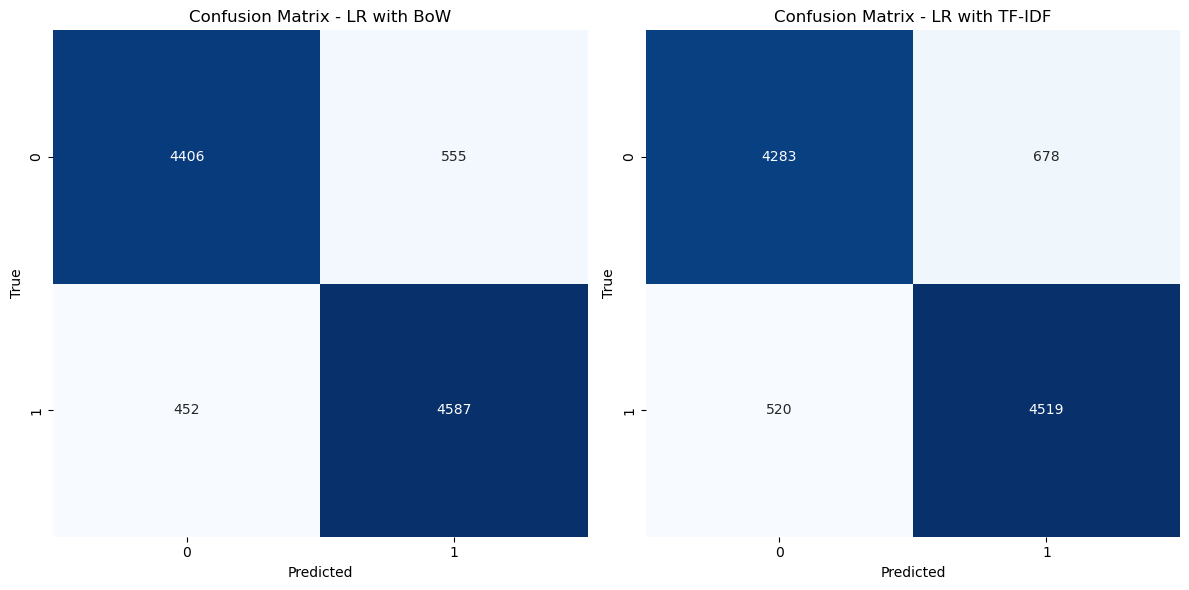

In [115]:
# Confusion Matrix
conf_matrix_bow = confusion_matrix(y_test, lr_bow_predict)
conf_matrix_tfidf = confusion_matrix(y_test, lr_tfidf_predict)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Confusion Matrix - BoW
sns.heatmap(conf_matrix_bow, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Confusion Matrix - LR with BoW')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
# Confusion Matrix - TF-IDF
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix - LR with TF-IDF')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

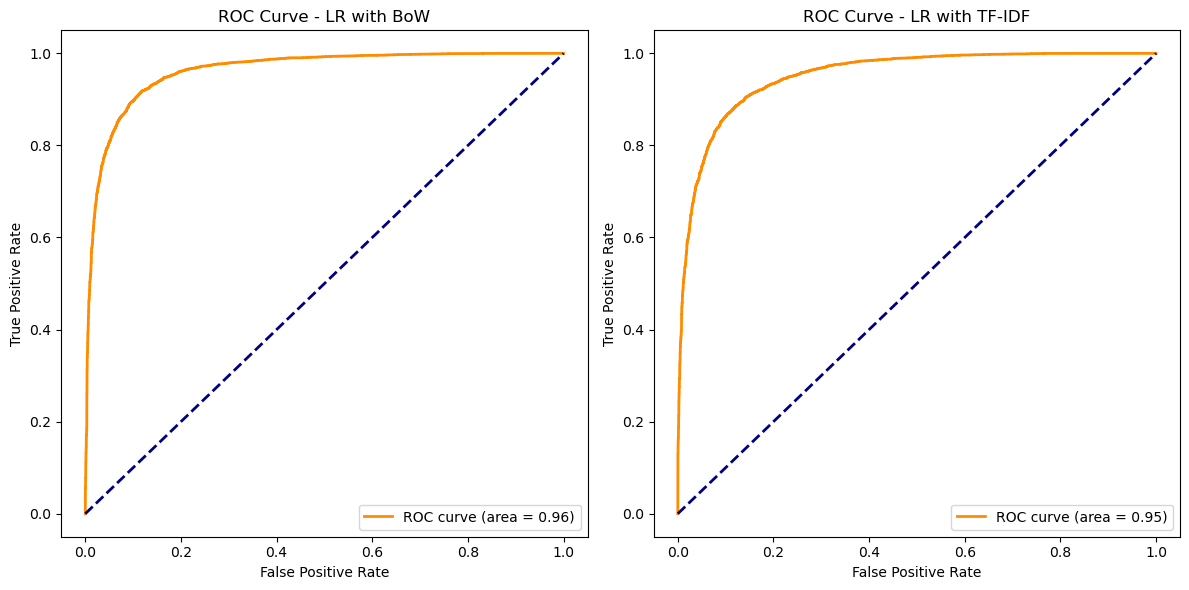

In [116]:
# ROC Curves
y_prob_bow = lr_bow.predict_proba(cv_X_test)[:, 1]
fpr_bow, tpr_bow, thresholds_bow = roc_curve(y_test, y_prob_bow)
roc_auc_bow = auc(fpr_bow, tpr_bow)

y_prob_tfidf = lr_tfidf.predict_proba(tv_X_test)[:, 1]
fpr_tfidf, tpr_tfidf, thresholds_tfidf = roc_curve(y_test, y_prob_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

# Create subplots
plt.figure(figsize=(12, 6))

# BoW ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_bow, tpr_bow, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_bow))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR with BoW')
plt.legend(loc='lower right')

# TF-IDF ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr_tfidf, tpr_tfidf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_tfidf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR with TF-IDF')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### 2. Random Forest

In [117]:
# # Random Forest with Bag of Words
# rf_bow = RandomForestClassifier(n_jobs=-1, random_state=42)
# rf_bow.fit(cv_X_train, y_train)
# rf_bow_predict = rf_bow.predict(cv_X_test)
# rf_bow_score = accuracy_score(y_test, rf_bow_predict)
# print("Random Forest with Bag of Words Embeddings:", rf_bow_score)

Random Forest with Bag of Words Embeddings: 0.8634
Random Forest with TF-IDF Embeddings: 0.8565


In [118]:
# # Random Forest with TF-IDF
# rf_tfidf = RandomForestClassifier(n_jobs=-1, random_state=42)
# rf_tfidf.fit(tv_X_train, y_train)
# rf_tfidf_predict = rf_tfidf.predict(tv_X_test)
# rf_tfidf_score = accuracy_score(y_test, rf_tfidf_predict)
# print("Random Forest with TF-IDF Embeddings:", rf_tfidf_score)

Random Forest with TF-IDF Embeddings: 0.8565


In [138]:
# #Classification report for bag of words 
# rf_bow_report=classification_report(y_test,rf_bow_predict,target_names=['Positive','Negative'])
# print("Random Forest with BoW:\n", lr_bow_report)

# #Classification report for tfidf features
# rf_tfidf_report=classification_report(y_test,rf_tfidf_predict,target_names=['Positive','Negative'])
# print("Random Forest with TF-IDF:\n", lr_tfidf_report)

Random Forest with BoW:
               precision    recall  f1-score   support

    Positive       0.85      0.84      0.85      4961
    Negative       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Random Forest with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.86      0.83      0.85      4961
    Negative       0.84      0.87      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Accuracies:\
Random Forest with Bag of Words Embeddings: 0.8634\
Random Forest with TF-IDF Embeddings: 0.8565

Random Forest with BoW:
               precision    recall  f1-score   support

    Positive       0.85      0.84      0.85      4961
    Negative       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000\
weighted avg       0.85      0.85      0.85     10000

Random Forest with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.86      0.83      0.85      4961
    Negative       0.84      0.87      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000\
weighted avg       0.85      0.85      0.85     10000



Hyperparamter Tuning

In [141]:
# param_grid_rf = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search_rf = GridSearchCV(rf_bow, param_grid_rf, cv=5, scoring='accuracy')
# grid_search_rf.fit(cv_X_train, y_train)

# # Get the best Random Forest model and its hyperparameters
# best_rf_model = grid_search_rf.best_estimator_
# best_rf_params = grid_search_rf.best_params_

# # Use the best Random Forest model to make predictions on the test set
# y_pred_rf = best_rf_model.predict(cv_X_test)

# # Calculate and print the accuracy of the best Random Forest model
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print("Best Hyperparameters:", best_rf_params)
# print("Accuracy of the Best Random Forest Model:", accuracy_rf)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy of the Best Random Forest Model: 0.8358


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}\
Accuracy of the Best Random Forest Model: 0.8358

### 3. XGBoost

In [119]:
# xgb_bow = XGBClassifier(random_state=42)
# xgb_tfidf = XGBClassifier(random_state=42)

# # Fit models
# xgb_bow.fit(cv_X_train, y_train)
# xgb_tfidf.fit(tv_X_train, y_train)

# # Predictions
# y_pred_bow = xgb_bow.predict(cv_X_test)
# y_pred_tfidf = xgb_tfidf.predict(tv_X_test)

# # Evaluate models
# accuracy_bow = accuracy_score(y_test, y_pred_bow)
# accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

# print("Accuracy - XGBoost with BoW:", accuracy_bow)
# print("Accuracy - XGBoost with TF-IDF:", accuracy_tfidf)

Accuracy - XGBoost with BoW: 0.8614
Accuracy - XGBoost with TF-IDF: 0.8531


Accuracy - XGBoost with BoW: 0.8614\
Accuracy - XGBoost with TF-IDF: 0.8531

XGBoost with BoW:
               precision    recall  f1-score   support

    Positive       0.88      0.84      0.86      4961
    Negative       0.85      0.88      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000\
weighted avg       0.86      0.86      0.86     10000

XGBoost with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.87      0.83      0.85      4961
    Negative       0.84      0.88      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000\
weighted avg       0.85      0.85      0.85     10000

In [139]:
# #Classification report for bag of words 
# xgb_bow_report=classification_report(y_test,y_pred_bow,target_names=['Positive','Negative'])
# print("XGBoost with BoW:\n", xgb_bow_report)

# #Classification report for tfidf features
# xgb_tfidf_report=classification_report(y_test,y_pred_tfidf,target_names=['Positive','Negative'])
# print("XGBoost with TF-IDF:\n", xgb_tfidf_report)

XGBoost with BoW:
               precision    recall  f1-score   support

    Positive       0.88      0.84      0.86      4961
    Negative       0.85      0.88      0.87      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

XGBoost with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.87      0.83      0.85      4961
    Negative       0.84      0.88      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Hyperparamter Tuning

In [142]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}
grid_search_rf = GridSearchCV(xgb_bow, param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(cv_X_train, y_train)

# Get the best Random Forest model and its hyperparameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

# Use the best Random Forest model to make predictions on the test set
y_pred_rf = best_rf_model.predict(cv_X_test)

# Calculate and print the accuracy of the best Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Best Hyperparameters:", best_rf_params)
print("Accuracy of the Best XGBoost Model:", accuracy_rf)

[23:23:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[23:23:30] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[23:23:31] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[23:23:32] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

[23:23:33] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:76

KeyboardInterrupt: 

#### Using the opinion lexicon

In [127]:
null_review_rows = imdb_data[imdb_data.lexicon_reviews.isnull()]
imdb_data.loc[null_review_rows.index, 'lexicon_reviews'] = null_review_rows['review']
imdb_data.lexicon_reviews.isna().sum()

0

In [128]:
X = imdb_data['lexicon_reviews']
y = imdb_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_train.shape)

(40000,) (40000,)
(10000,) (40000,)


In [129]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)
print("BoW_cv_train:", cv_X_train.shape)
print("Bow_cv_test:", cv_X_test.shape)

BoW_cv_train: (40000, 6760)
Bow_cv_test: (10000, 6760)


In [131]:
tf = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tv_X_train = tf.fit_transform(X_train)
tv_X_test = tf.transform(X_test)
print("Tfidf_train:", tv_X_train.shape)
print("Tfidf_test:", tv_X_test.shape)

Tfidf_train: (40000, 926175)
Tfidf_test: (10000, 926175)


In [132]:
lr_bow_m = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
#fitting the model for Bag of Words embeddings 
lr_bow = lr_bow_m.fit(cv_X_train, y_train)
lr_bow_predict = lr_bow_m.predict(cv_X_test)
#fitting the model for the tfidf embeddings 
lr_tfidf_m = LogisticRegression(penalty='l2', max_iter=500, random_state=42)
lr_tfidf = lr_tfidf_m.fit(tv_X_train, y_train)
lr_tfidf_predict = lr_tfidf_m.predict(tv_X_test)

In [133]:
#accuracy scores of both models 
lr_bow_score = accuracy_score(y_test, lr_bow_predict)
lr_tfidf_score = accuracy_score(y_test, lr_tfidf_predict)
print("Logistic Regression with Bag of Words Embeddings:", lr_bow_score)
print("Logistic Regression with TF-IDF Embeddings:", lr_tfidf_score)

Logistic Regression with Bag of Words Embeddings: 0.8476
Logistic Regression with TF-IDF Embeddings: 0.8495


Logistic Regression with Bag of Words Embeddings: 0.8476\
Logistic Regression with TF-IDF Embeddings: 0.8495

In [134]:
#Classification report for bag of words 
lr_bow_report=classification_report(y_test,lr_bow_predict,target_names=['Positive','Negative'])
print("Logistic Regression with BoW:\n", lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,lr_tfidf_predict,target_names=['Positive','Negative'])
print("Logistic Regression with TF-IDF:\n", lr_tfidf_report)

Logistic Regression with BoW:
               precision    recall  f1-score   support

    Positive       0.85      0.84      0.85      4961
    Negative       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Logistic Regression with TF-IDF:
               precision    recall  f1-score   support

    Positive       0.86      0.83      0.85      4961
    Negative       0.84      0.87      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Final accuracies of different models: (w/o dimension reduction)
1. Logistic Regression:

a. with all the words:\
BoW: 0.8993\
TF-IDF: 0.8802

b. with just the words from the opinion lexicon:\
BoW: 0.8476\
TF-IDF: 0.8495

2. Random Forest:

a. w/o hyperparameter tuning:\
BoW: 0.8634\
TF-IDF: 0.8565

b. w/ hyperparameter tuning:\
BoW: 0.8358


3. XGBoost: 

a. w/o hyperparameter tuning:\
BoW: 0.8614
TF-IDF: 0.8531

b. w/ hyperparameter tuning:\
code crashed so will need to reduce dim
